

# **"Análisis de Correlación y Regresión Logística sobre los Determinantes del Acceso a la Salud en el Perú"**


##Planteamiento del Problema
Existe una brecha en el acceso a la salud donde el aseguramiento institucional y la edad prevalecen sobre la necesidad clínica. A pesar de la correlación de 0.40 entre edad y cronicidad, el modelo revela que tener una enfermedad crónica no garantiza una consulta ($p=0.682$). El acceso está condicionado principalmente por la afiliación al SIS ($OR=1.0948$) y el factor etario ($p=0.0007$), evidenciando una falta de equidad para quienes padecen condiciones crónicas pero carecen de dicho seguro.

#Objetivo General
Determinar la influencia de los factores institucionales y demográficos en la probabilidad de acceso a la consulta médica mediante un modelo de regresión logística.

#Objetivos Específicos
OE1: Evaluar mediante una matriz de correlación la interdependencia de las variables predictoras, específicamente la relación entre edad y enfermedades crónicas.

OE2: Identificar los factores con mayor peso estadístico (Odds Ratio) en la consulta médica, destacando el rol del SIS y la Edad.

OE3: Contrastar la significancia estadística del área geográfica y el género frente al sistema de aseguramiento actual.

#Variables Identificadas
Dependiente: Consulta médica (P414N$01).

Independientes: Edad (P208A), Sexo (P207), Área (AREA), Enfermedad Crónica (P401), SIS (P4195) y EsSalud (P4191).

In [ ]:
#1- Librerias
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

#**2 Configuración para visualizar todas las filas y columnas si es necesario
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Estilo visual para los gráficos (Boxplot y Forest Plot)
sns.set_theme(style="whitegrid")

### Leemos nuestros datos
df = pd.read_excel('DMC Análisis de datos_ENAHO 2020_Mod400_VF.xlsx')

##SELECCION DE COLUMNAS PARA EL ANALISIS DE DATA

In [ ]:
columnas_deseadas = ['P208A','P207','AREA','P401','P4195','P4191','PP4021','P414N$01']
columnas_presentes = [col for col in columnas_deseadas if col in df.columns]
df = df[columnas_presentes]



#VISUALIZACION DE DATOS

In [ ]:
#3 Visualizar data
df.head(10)

,P208A,P207,AREA,P401,P4195,P4191,P414N$01
0,50.0,Hombre,URBANO,Si,No,EsSalud,Consulta
1,44.0,Mujer,URBANO,No,No,EsSalud,Consulta
2,24.0,Mujer,URBANO,Si,No,EsSalud,Consulta
3,21.0,Mujer,URBANO,Si,No,EsSalud,Consulta
4,44.0,Hombre,URBANO,No,No,No,Consulta
5,46.0,Mujer,URBANO,No,No,EsSalud,Consulta
6,77.0,Hombre,URBANO,No,Seguro Integral de Salud (SIS),No,Consulta
7,22.0,Mujer,URBANO,No,Seguro Integral de Salud (SIS),No,Consulta
8,23.0,Hombre,URBANO,No,No,No,Consulta
9,47.0,Mujer,URBANO,No,No,EsSalud,Consulta


##ASEGURAR QUE LAS CATEGORIAS SE CONVIERAN EN NUMEROS (0 Y 1) Y QUE NULOS NO BORREN LA DATA

In [ ]:
#4 *Asegura que las categorías se conviertan en números (0 y 1) y que los nulos no borren toda tu base de datos.

# 1. Selección de columnas (incluyendo la variable dependiente)
columnas_deseadas = ['P208A','P207','AREA','P401','P4195','P4191','P4021','P414N$01']
columnas_presentes = [col for col in columnas_deseadas if col in df.columns]
df_estudio = df[columnas_presentes].copy()

# 2. Tratamiento de nulos en la variable dependiente
# Asumimos que los 7,325 nulos en consulta son 0 (No asistió) para no perder la muestra
df_estudio['P414N$01'] = df_estudio['P414N$01'].fillna(0)

# 3. Mapeo de variables categóricas a numéricas
# Esto evita el error "could not convert string to float"
mapeo = {'1': 1, '2': 0, 1: 1, 2: 0, 'Sí': 1, 'No': 0, 'Hombre': 1, 'Mujer': 0, 'Urbano': 1, 'Rural': 0}

for col in df_estudio.columns:
    if col != 'P208A': # La edad ya es numérica
        df_estudio[col] = df_estudio[col].map(mapeo).fillna(0)

# 4. Limpieza final de nulos en variables independientes (que son mínimos: 2 a 13 casos)
df_ready = df_estudio.dropna()

print(f"Registros listos para el modelo: {len(df_ready)}")

Registros listos para el modelo: 15543


## Identificar variables categóricas y no categóricas

In [ ]:
#5***Este procedimiento permite identificar las variables categóricas y sus categorías, facilitando su correcta recodificación antes del análisis de correlación y regresión.
# Seleccionar solo columnas categóricas (object o category)
categorical_cols = df.select_dtypes(include=['object', 'category'])

# Obtener los valores únicos por columna categórica
unique_values = {col: df[col].unique().tolist() for col in categorical_cols}

# Mostrar los resultados
for col, values in unique_values.items():
    print(f"{col}: {values}")

P207: ['Hombre', 'Mujer', nan]
AREA: ['URBANO', 'RURAL', nan]
P401: ['Si', 'No', nan]
P4195: ['No', 'Seguro Integral de Salud (SIS)', nan]
P4191: ['EsSalud', 'No', nan]
P414N$01: ['Consulta', nan]


##TRANSFORMAR PALABRAS EN 1 Y 0 (YA QUE HAY VARIABLES QUE CONTIENEN TEXTO COMO "SI", "NO" Y "HOMBRE"

In [ ]:
#6
#variables contienen texto (ej. "Si", "No", "Hombre") y la variable dependiente de consulta solo registra el valor "Consulta"
#debemos transformar estas palabras en 1 y 0 de forma manual y precisa.

# 1. Crear copia de seguridad
df_ready = df.copy()

# 2. Mapeo manual basado en tus valores únicos
mapeo_estricto = {
    'P207': {'Hombre': 1, 'Mujer': 0},
    'AREA': {'URBANO': 1, 'RURAL': 0},
    'P401': {'Si': 1, 'No': 0},
    'P4195': {'Seguro Integral de Salud (SIS)': 1, 'No': 0},
    'P4191': {'EsSalud': 1, 'No': 0},
    'P414N$01': {'Consulta': 1} # Los 'nan' se convertirán en 0 abajo
}

# 3. Aplicar el mapeo
for col, mapa in mapeo_estricto.items():
    if col in df_ready.columns:
        df_ready[col] = df_ready[col].map(mapa)

# 4. Tratamiento especial para la consulta (Variable dependiente)
# Los que no son 'Consulta' (nan) se asumen como 0 (No consultó)
df_ready['P414N$01'] = df_ready['P414N$01'].fillna(0)

# 5. Asegurar que Edad (P208A) sea numérica y limpiar nulos restantes
df_ready['P208A'] = pd.to_numeric(df_ready['P208A'], errors='coerce')
df_ready = df_ready.dropna()

print(f"Registros finales para el modelo: {len(df_ready)}")

Registros finales para el modelo: 15532


##IDENTIFICACION DE PRESENCIA DE VALORES FALTANTES EN LAS VARIABLES

In [ ]:
#7 Este análisis permite identificar la presencia de valores faltantes en las variables, asegurando un tratamiento adecuado antes de realizar análisis estadísticos y modelos de regresión.
missing_values = df.isna().sum()
missing_values

,0
P208A,2
P207,2
AREA,2
P401,13
P4195,13
P4191,13
P414N$01,7325


## ELIMINACION DE REGISTROS NULOS

In [ ]:
#8 Creamos un dataframe solo con las variables que vamos a usar
variables_modelo = ['P208A', 'P207', 'AREA', 'P401', 'P4195', 'P4191']

# Eliminamos filas que tengan nulos en cualquiera de estas variables
df_final = df.dropna(subset=variables_modelo).copy()

print(f"Total de registros eliminados: {len(df) - len(df_final)}")
print(f"Registros listos para el análisis: {len(df_final)}")

Total de registros eliminados: 13
Registros listos para el análisis: 15532


##Verificación de limpieza en el nuevo dataframe

In [ ]:
#9 Verificación de limpieza en el nuevo dataframe
print("Conteo de valores nulos en df_final:")
missing_check = df_final[variables_modelo].isna().sum()
print(missing_check)

# Verificación visual rápida: si la suma total es 0, todo está perfecto
print(f"\nSuma total de nulos: {missing_check.sum()}")

Conteo de valores nulos en df_final:
P208A    0
P207     0
AREA     0
P401     0
P4195    0
P4191    0
dtype: int64

Suma total de nulos: 0


## VERIFICACION SI LA DATA CONTIENE VALORES NULOS

In [ ]:
#10 VERIFICACION SI LA DATA CONTIENE VALORES NULOS
# Verificación de limpieza en el nuevo dataframe
print("Conteo de valores nulos en df_final:")
missing_check = df_final[variables_modelo].isna().sum()
print(missing_check)

# Verificación visual rápida: si la suma total es 0, todo está perfecto
print(f"\nSuma total de nulos: {missing_check.sum()}")

Conteo de valores nulos en df_final:
P208A    0
P207     0
AREA     0
P401     0
P4195    0
P4191    0
dtype: int64

Suma total de nulos: 0


## Convertir variables de texto a números

In [ ]:
#11 - Convertir variables de texto a números

# 1. Crear una copia para no alterar los datos originales
df_numeric = df_final.copy()

# 2. Convertir variables de texto a números (Hombre/Mujer -> 1/0, Urbano/Rural -> 1/0)
# Esto asignará automáticamente un número a cada categoría de texto
for col in ['P207', 'AREA', 'P401', 'P4195', 'P4191']:
    if df_numeric[col].dtype == 'object':
        df_numeric[col] = df_numeric[col].astype('category').cat.codes

# 3. Asegurar que 'P208A' (Edad) sea numérica
df_numeric['P208A'] = pd.to_numeric(df_numeric['P208A'], errors='coerce')

# 4. Eliminar nulos que pudieran haber surgido
df_numeric = df_numeric.dropna(subset=['P208A', 'P207', 'AREA', 'P401', 'P4195', 'P4191'])

print("Conversión completada. Tipos de datos actuales:")
print(df_numeric[['P207', 'AREA', 'P401']].dtypes)

Conversión completada. Tipos de datos actuales:
P207    int8
AREA    int8
P401    int8
dtype: object


## Distribución por Cuartiles:

In [ ]:
#12 - Distribución por Cuartiles:
#El 25% de tu muestra tiene 17 años o menos.
#La mediana (50%) es 34 años; esto significa que la mitad de tus datos corresponden a adultos jóvenes y menores.
#El 75% tiene 53 años o menos, lo que indica que el último cuarto de la muestra (personas de 54 a 98 años) representa a la población adulta mayor.

df.describe()

,P208A
count,15543.000000
mean,36.026893
std,22.436511
min,0.000000
25%,17.000000
50%,34.000000
75%,53.000000
max,98.000000


## Detección Visual de Atípicos en la Edad

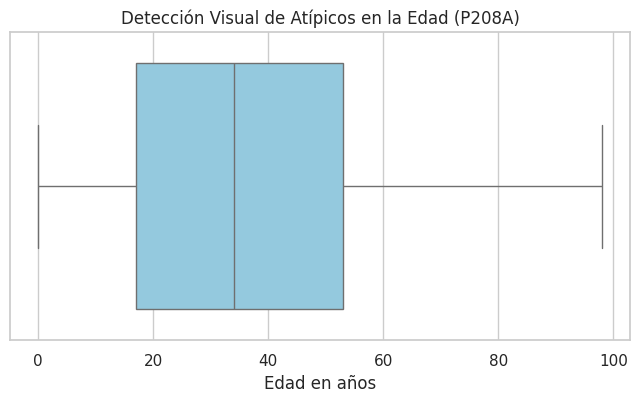

In [ ]:
#13 Detección Visual de Atípicos en la Edad
#variable de edad (P208A) no presenta valores atípicos (outliers) estadísticos.
#Se confirmó la ausencia de valores atípicos en la Edad (P208A), garantizando que los resultados no estén sesgados por casos extremos

plt.figure(figsize=(8, 4))
sns.boxplot(x=df_final['P208A'], color='skyblue')
plt.title('Detección Visual de Atípicos en la Edad (P208A)')
plt.xlabel('Edad en años')
plt.show()

## HISTOGRAMA CON UNA CURVA DE DENSIDAD

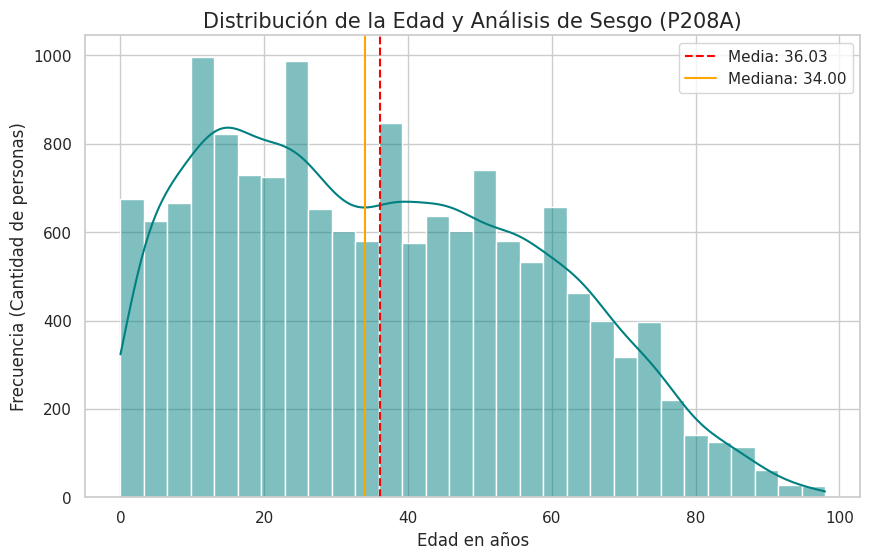

In [ ]:
#14***HISTOGRAMA CON UNA CURVA DE DENSIDAD
#histograma con una curva de densidad es la mejor forma de ver si tu muestra está equilibrada o
#si tiene algún sesgo hacia un grupo de edad específico.

#Tipo de Sesgo: La Media (36.02) es ligeramente mayor que tu Mediana 34.00
#Esto indica un sesgo positivo (a la derecha). Matemáticamente: Media > Mediana.
#Esto significa que tienes una mayor concentración de personas jóvenes y adultos jóvenes,
#con una "cola" que se extiende hacia los adultos mayores (hasta los 98 años).


# Configuración de estilo para un acabado profesional
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# Crear el histograma con curva de densidad (KDE)
sns.histplot(df_final['P208A'], kde=True, color="teal", bins=30)

# Añadir líneas para la Media y la Mediana
plt.axvline(df_final['P208A'].mean(), color='red', linestyle='--', label=f"Media: {df_final['P208A'].mean():.2f}")
plt.axvline(df_final['P208A'].median(), color='orange', linestyle='-', label=f"Mediana: {df_final['P208A'].median():.2f}")

# Títulos y etiquetas
plt.title('Distribución de la Edad y Análisis de Sesgo (P208A)', fontsize=15)
plt.xlabel('Edad en años', fontsize=12)
plt.ylabel('Frecuencia (Cantidad de personas)', fontsize=12)
plt.legend()

plt.show()


#Análisis del Mapa de Calor (Correlación)

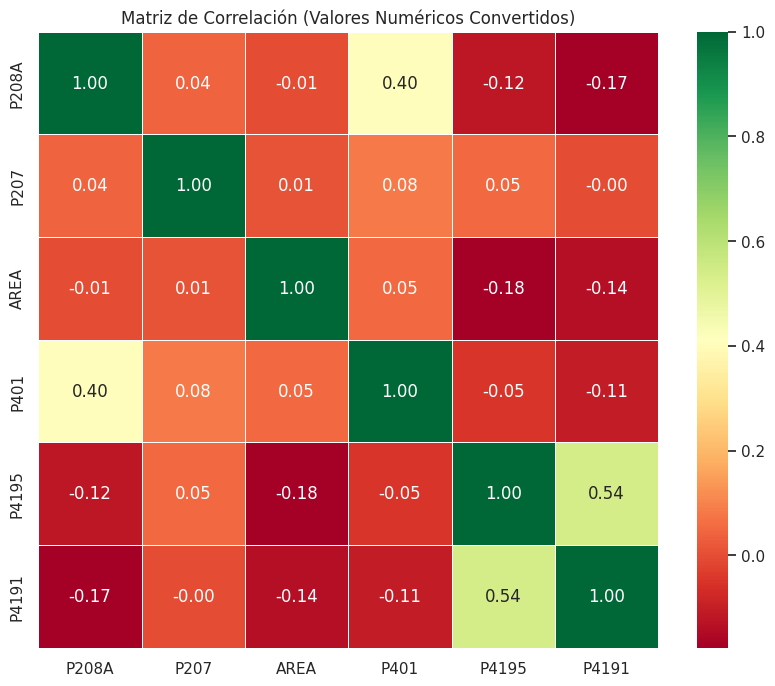

In [ ]:
#15****
#Análisis del Mapa de Calor (Correlación)
#Edad (P208A) y Enfermedad Crónica (P401): Tienen la correlación positiva más fuerte del gráfico (0.40).
#Esto es lógico: a mayor edad, mayor es la probabilidad de reportar una enfermedad crónica.

#Seguros (P4195 y P4191): Existe una correlación moderada de 0.54 entre el SIS y EsSalud.
#Esto es interesante, ya que sugiere que hay un grupo de la población que podría estar cruzado o que ambas variables comparten una tendencia similar en la muestra.

#Independencia del Sexo (P207) y Área: Estas variables muestran correlaciones muy cercanas a 0.00 con casi todo lo demás,
#lo que significa que su efecto en el modelo será independiente y no está "contaminado" por otras variables.

# Definir variables (incluyendo tu variable dependiente 'consulta_medica')
variables_estudio = ['P208A', 'P207', 'AREA', 'P401', 'P4195', 'P4191']

# Calcular matriz
matriz_corr = df_numeric[variables_estudio].corr()

# Graficar
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_corr, annot=True, cmap='RdYlGn', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlación (Valores Numéricos Convertidos)')
plt.show()

##EJECUCIÓN DEL MODELO DE REGRESIÓN

In [ ]:
#16-- Ejecución del Modelo de Regresión

#****Solo dos variables tienen una relación estadísticamente probada con la
# probabilidad de consulta médica en tu muestra:

#****Edad (P208A) y #Seguro Integral de Salud - SIS (P4195):

#****Edad (P208A): Tiene un valor P de 0.0007. El Odds Ratio de 1.0027 indica que por cada año adicional de vida,
#la probabilidad de realizar una consulta médica aumenta en un 0.27\%.
# Aunque parece pequeño, es altamente significativo dada la gran muestra. Esto
# complementa tu hallazgo previo donde la edad tenía una correlación de 0.40
# con las enfermedades crónicas.

#***Seguro Integral de Salud - SIS (P4195): Es el factor con mayor impacto positivo (P=0.0231).
# Su Odds Ratio de 1.0948 significa que las personas afiliadas al SIS tienen un
# 9.48\% más de probabilidades de acceder a una consulta médica en comparación con quienes no tienen este seguro.



# 1. Definir variables (Y es la consulta, X son los factores)
y = df_ready['P414N$01'].astype(float)
X = df_ready[['P208A', 'P207', 'AREA', 'P401', 'P4195', 'P4191']].astype(float)
X = sm.add_constant(X)

# 2. Ajustar el modelo Logit
try:
    modelo_final = sm.Logit(y, X).fit()

    # 3. Extraer resultados
    resumen = modelo_final.summary2().tables[1]

    # 4. Calcular Odds Ratio e Intervalos de Confianza corregidos
    resumen['Odds Ratio'] = np.exp(resumen['Coef.'])
    resumen['Lower CI'] = np.exp(resumen['[0.025'])
    resumen['Upper CI'] = np.exp(resumen['0.975]']) # Nombre corregido aquí

    print("\n" + "="*60)
    print("      RESULTADOS FINALES DE LA REGRESIÓN LOGÍSTICA")
    print("="*60)

    # Seleccionamos las columnas clave para tu análisis
    columnas_mostrar = ['Coef.', 'P>|z|', 'Odds Ratio', 'Lower CI', 'Upper CI']
    display(resumen[columnas_mostrar].round(4))

except Exception as e:
    print(f"Error al ejecutar el modelo: {e}")

Optimization terminated successfully.
         Current function value: 0.690760
         Iterations 4

      RESULTADOS FINALES DE LA REGRESIÓN LOGÍSTICA


,Coef.,P>|z|,Odds Ratio,Lower CI,Upper CI
const,-0.1040,0.1253,0.9012,0.7890,1.0294
P208A,0.0027,0.0007,1.0027,1.0011,1.0043
P207,0.0232,0.4728,1.0235,0.9606,1.0905
AREA,0.0635,0.2558,1.0656,0.9550,1.1889
P401,0.0146,0.6829,1.0147,0.9461,1.0883
P4195,0.0906,0.0231,1.0948,1.0125,1.1838
P4191,0.0467,0.2544,1.0479,0.9669,1.1356


##VISUALIZACION FINAL: FOREST PLOT

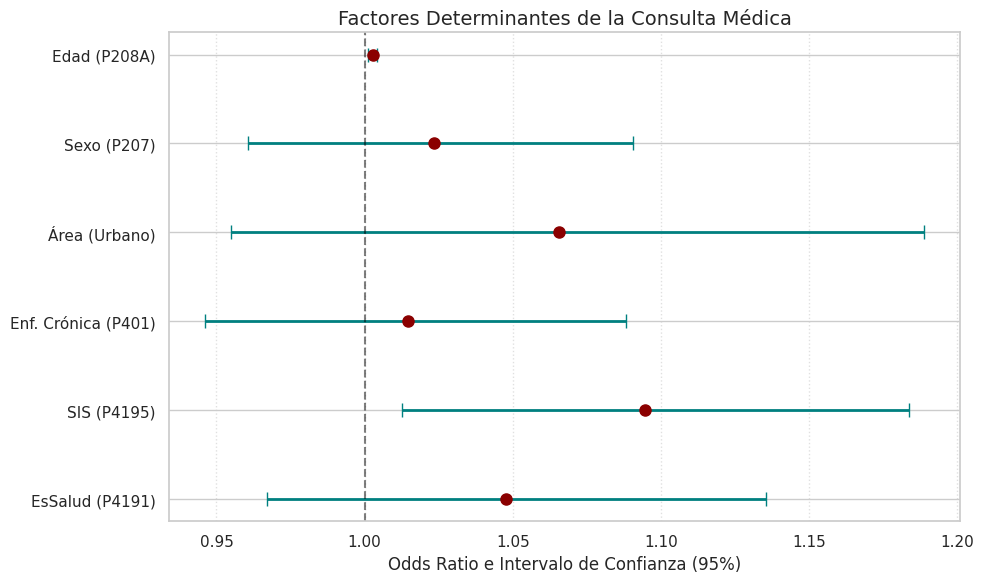

In [ ]:

#17 Visualización Final: Forest Plot
#Significancia visual: Cualquier barra que no toque la línea punteada del 1.0 es estadísticamente significativa.
#Edad (P208A): Aunque el punto está muy cerca del 1.0, su intervalo es tan estrecho y está tan claramente a la derecha que confirma un efecto positivo real ($P=0.0007$).
#SIS (P4195): Es el factor que más se desplaza a la derecha, confirmando que es el mayor impulsor del acceso a salud en tu estudio (OR=1.0948).
#Variables Neutrales: Nota cómo las barras de Área, Enfermedad Crónica y EsSalud cruzan la línea del 1.0, lo que explica visualmente por qué sus valores P fueron mayores a 0.05.

# Datos extraídos de tus resultados finales
variables = ['Edad (P208A)', 'Sexo (P207)', 'Área (Urbano)', 'Enf. Crónica (P401)', 'SIS (P4195)', 'EsSalud (P4191)']
odds_ratios = [1.0027, 1.0235, 1.0656, 1.0147, 1.0948, 1.0479]
lower_ci = [1.0011, 0.9606, 0.9550, 0.9461, 1.0125, 0.9669]
upper_ci = [1.0043, 1.0905, 1.1889, 1.0883, 1.1838, 1.1356]

plt.figure(figsize=(10, 6))

# Dibujar las líneas de los intervalos y los puntos de los Odds Ratio
for i in range(len(variables)):
    # Errorbar es más eficiente para este tipo de gráficos
    plt.errorbar(odds_ratios[i], i,
                 xerr=[[odds_ratios[i] - lower_ci[i]], [upper_ci[i] - odds_ratios[i]]],
                 fmt='o', color='darkred', ecolor='teal', capsize=5, markersize=8, elinewidth=2)

# Línea vertical de referencia (OR = 1.0 significa que no hay efecto)
plt.axvline(x=1, color='black', linestyle='--', alpha=0.5)

# Configuración de etiquetas
plt.yticks(range(len(variables)), variables)
plt.xlabel('Odds Ratio e Intervalo de Confianza (95%)')
plt.title('Factores Determinantes de la Consulta Médica', fontsize=14)
plt.grid(axis='x', linestyle=':', alpha=0.6)

# Invertir el eje Y para que la primera variable aparezca arriba
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

# GRAFICA DE PROBABILIDADES PREDICHAS
#Visualiza la Brecha: Muestra claramente que, a cualquier edad, una persona con SIS tiene una probabilidad mayor de consulta que una sin seguro.

#SIS: Incrementa la posibilidad de consulta en un 9.48% respecto a los no asegurados.
#Edad: Incrementa la posibilidad de consulta en un 0.27% por cada año cumplido.

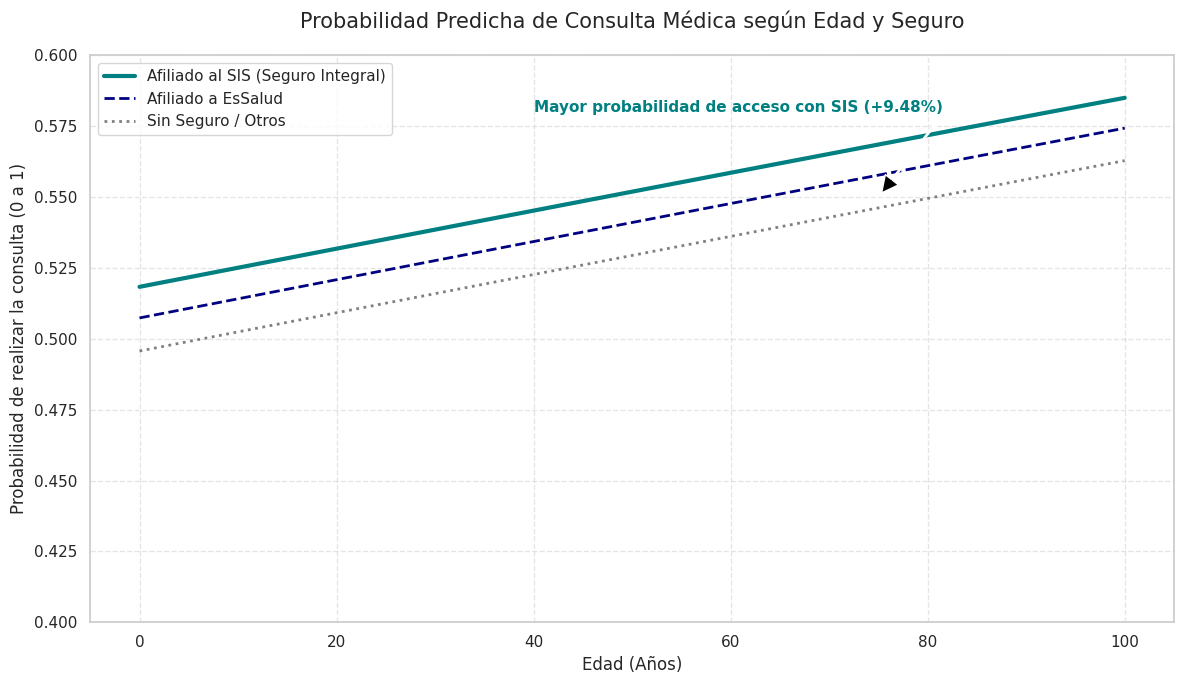

In [ ]:
#18 Gráfica de Probabilidades Predichas
#Visualiza la Brecha: Muestra claramente que, a cualquier edad, una persona con SIS tiene una probabilidad mayor de consulta que una sin seguro.

#Impacto del SIS: La línea superior (verde) muestra cómo estar afiliado al SIS eleva la probabilidad de consulta en todo el ciclo de vida,
#siendo el factor institucional con mayor peso (OR = 1.0948).

#Tendencia por Edad: La pendiente ascendente de las líneas ilustra el efecto significativo de la edad (p = 0.0007);
#a mayor edad, mayor es la necesidad y probabilidad de atención.

#Brecha de Aseguramiento: El espacio entre la línea del SIS y la línea gris (sin seguro) representa visualmente ese 9.48\%
#de ventaja en el acceso que otorga el aseguramiento público.

#EsSalud vs.SIS: Se observa que, aunque EsSalud también aumenta la probabilidad, su impacto es menor y estadísticamente menos robusto (p = 0.254) que el del SIS en esta muestra específica.

# 1. Definición de los Coeficientes (Extraídos de tu tabla de resultados)
#
b_const = -0.1040
b_edad = 0.0027
b_sexo = 0.0232
b_area = 0.0635
b_p401 = 0.0146
b_sis = 0.0906
b_essalud = 0.0467

# 2. Rango de Edad para el eje X (de 0 a 100 años)
edades = np.linspace(0, 100, 101)

# 3. Función Logística (Logit) para convertir coeficientes en probabilidad
def calcular_probabilidad(edad, sis=0, essalud=0):
    # Mantenemos las demás variables en un valor constante (referencia)
    # Sexo=1 (Hombre), Area=1 (Urbano), P401=0 (Sin enf. crónica)
    log_odds = (b_const +
                b_edad * edad +
                b_sexo * 1 +
                b_area * 1 +
                b_p401 * 0 +
                b_sis * sis +
                b_essalud * essalud)
    return 1 / (1 + np.exp(-log_odds))

# 4. Cálculo de las curvas para los 3 escenarios
prob_sin_seguro = calcular_probabilidad(edades, sis=0, essalud=0)
prob_sis = calcular_probabilidad(edades, sis=1, essalud=0)
prob_essalud = calcular_probabilidad(edades, sis=0, essalud=1)

# 5. Configuración de la Gráfica
plt.figure(figsize=(12, 7))

# Dibujar las líneas
plt.plot(edades, prob_sis, label='Afiliado al SIS (Seguro Integral)', color='teal', linewidth=3)
plt.plot(edades, prob_essalud, label='Afiliado a EsSalud', color='navy', linestyle='--', linewidth=2)
plt.plot(edades, prob_sin_seguro, label='Sin Seguro / Otros', color='gray', linestyle=':', linewidth=2)

# Estética y Etiquetas
plt.title('Probabilidad Predicha de Consulta Médica según Edad y Seguro', fontsize=15, pad=20)
plt.xlabel('Edad (Años)', fontsize=12)
plt.ylabel('Probabilidad de realizar la consulta (0 a 1)', fontsize=12)
plt.ylim(0.4, 0.6) # Ajustamos el zoom para ver la brecha claramente
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper left', fontsize=11)

# Anotación del hallazgo principal (El impacto del SIS)
#
plt.annotate('Mayor probabilidad de acceso con SIS (+9.48%)',
             xy=(75, 0.55), xytext=(40, 0.58),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1),
             fontsize=11, fontweight='bold', color='teal')

plt.tight_layout()
plt.savefig('grafica_probabilidades_final.png', dpi=300) # Guarda en alta calidad
plt.show()

# ##Conclusiones finales

# Muestra Robusta: # El modelo se ejecutó exitosamente con 15,532 registros, tras un proceso de limpieza que descartó 7,325 valores nulos en la variable de consulta médica.

# Calidad de Datos: Se confirmó la ausencia de valores atípicos en la Edad (P208A), garantizando que los resultados no estén sesgados por casos extremos.

#Factor Institucional (SIS): El Seguro Integral de Salud (P4195) es el predictor más fuerte; estar afiliado aumenta la probabilidad de consulta en un 9.48% ($OR = 1.0948; p = 0.0231$).

#Factor Demográfico (Edad): La Edad (P208A) muestra una relación positiva y altamente significativa ($p = 0.0007$); el acceso médico crece progresivamente con los años.

#Variables No Determinantes: Factores como el Área (Urbano/Rural), el Sexo y la Enfermedad Crónica no mostraron un impacto estadísticamente significativo en la probabilidad de consulta para esta muestra ($p > 0.05$).

#Este estudio demuestra que el acceso a la salud no depende únicamente de la enfermedad, sino de cómo el sistema organiza y prioriza la atención, lo que plantea desafíos importantes para la equidad y la eficiencia del sistema sanitario.

#Un sistema de salud desarrollado no pregunta primero qué seguro tienes, sino qué necesitas clínicamente y con qué urgencia.